This project was to look at the strategies of the repeated prisoner's dilemma, and how they functioned not only in a population but how that population changed over time if new automata (representing the agents) were addded in to replace the least successful automata.

In [ ]:
from collections import namedtuple 
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Node = namedtuple('Node', ['strategy','cooperate','defect'])

"""
This class represents the individual nodes constructing the automata
strat = whether they will cooperate/defect if their opponent cooperates 
coop = the node they will go to if their opponent cooperates
defect = the node they will go to if their opponent defects
"""
class Node:
    def __init__(self,strat=None,coop=None,defect=None):
        self.strat = strat
        self.coop = coop
        self.defect = defect
"""
The main class, this represents an automaton. It consists of the nodes and how they are connected.
It also updates the state of the automaton if its playing against another automaton
        
"""        
class Automaton:
    
    # Takes in whether given a graph structure or not
    # If not generates a default one
    def __init__(self, nodes=None):
        
        # The start node is the first
        self.start_node = 0
        
        # Starts at 0 points
        self.current_points = 0
        
        # Points values for different moves
        self.moves = {('C','C'):3, 
                      ('C','D'):0,
                      ('D','C'):5,
                      ('D','D'):1}
        
        # If not given a node structure to start, generates a default one
        if not nodes:
            node0 = Node('C',0,1)
            node1 = Node('D',0,1)
            self.nodes = [node0,
                          node1]
        else:
            self.nodes = nodes
        
        # The current node is the first node
        self.current_node = self.nodes[self.start_node]

    # Updates the automata depending on the moves
    # Returns the points that move led to
    def move(self, own_move, opp_move):
        points = self.moves[(own_move,opp_move)]
        self.current_points += points
        
        if opp_move == 'C':
            new_node = self.current_node.coop
        else:
            new_node = self.current_node.defect
        
        self.current_node = self.nodes[new_node]
        return points
    
    # Resets to 0 points and starts at the inital node again
    def reset(self):
        self.current_points = 0
        self.current_node = self.nodes[self.start_node]

    # Gets a hash of the automata
    # Very useful 
    def __hash__(self):
        nodes = tuple([(x.strat, x.coop, x.defect) for x in self.nodes])
        return hash(nodes)
        

In [ ]:
"""
This generates a random strategy for a node based on a percentage chance for cooperation
and it returns whether the node will cooperate 'C' or defect 'D'
"""
def get_nodestrat(p_coop):
    strat = {0:'C',1:'D'}
    res = random.choices([0,1],weights=[p_coop,1-p_coop])
    return strat[res[0]]

"""
This is an algorithm to generate a random graph of nodes that 
can be used for the basis of an automata. You can specify the number
of nodes, or that can be generated randomly
"""
def gen_random_network(no_nodes=None):
    # Chance of getting a co_op vs. defect node
    p_coop = 0.5
    p_defect = 1-p_coop
    
    # Chance of moving to a co-op vs. defect node
    p_move = 0.5
    
    if not no_nodes:
        no_nodes = random.randint(2,20)
    
    # Generates all nodes
    nodes = [Node() for i in range(no_nodes)]
    
    # To make sure all nodes are connected, 
    # initialise with path from initial to everyone else in random order
    visit_order = [i for i in range(1,no_nodes)]
    random.shuffle(visit_order)
    
    cur_node = 0
    for x in visit_order:
        c_or_d = random.randint(0,1)
        if c_or_d == 0:
            # Annoying to modify because tuples and stuff
            nodes[cur_node].coop = x
        else:
            nodes[cur_node].defect = x
        cur_node = x
    
    # Fill in the strategy for the nodes, and if they don't have connections, and their moves
    for i in range(no_nodes):
        nodes[i].strat = get_nodestrat(p_coop)
        if not nodes[i].coop:
            nodes[i].coop = random.randint(0,no_nodes-1)
        if not nodes[i].defect:
            nodes[i].defect = random.randint(0,no_nodes-1)
    
    return nodes
        
    
    

In [ ]:
"""
Plays out a competition between two automata,
and returns their final scores. Optional arguments are
the number of rounds, whether the score is reset before starting
and whether there is a printout of the results.
"""
def compete(fsm1, fsm2, no_rounds=100, reset=True, printout=True):
    # Reset points and states if reset
    if reset:
        fsm1.reset()
        fsm2.reset()
    
    fsm1_score = 0 
    fsm2_score = 0
    
    # Plays out the tournament and gets the scores
    for i in range(no_rounds):
        fsm1_move = fsm1.current_node.strat
        fsm2_move = fsm2.current_node.strat
        
        fsm1_score += fsm1.move(fsm1_move, fsm2_move)
        fsm2_score += fsm2.move(fsm2_move, fsm1_move)
    
    
    if printout:
        print(f'The final scores are FSM1:{fsm1_score} and FSM2:{fsm2_score}')
    
    return fsm1_score, fsm2_score
    

In [ ]:
# Prints out overview of automata
def view_nodes(nodes):
    for i,x in enumerate(nodes):
        print(f'Node {i} strat is {x.strat}, co-op is {x.coop}, defect is {x.defect}')


# Converts the nodes to a Digraph object
def to_graph(nodes):
    
    G = nx.DiGraph()
    
    defect_edges = [(i,nodes[i].defect,{'strat':'D'}) for i in range(len(nodes))]
    coop_edges = [(i,nodes[i].coop,{'strat':'C'}) for i in range(len(nodes))]
    
    G.add_edges_from(defect_edges)
    G.add_edges_from(coop_edges)
    
    G.nodes[0]['strat'] = 'S_' + nodes[0].strat
    
    for i in range(1,len(G)):
        G.nodes[i]['strat'] = nodes[i].strat 
    
    return G
 
# Shows all the nodes as a visisble graph
def view_graph(nodes):
    
    G = to_graph(nodes)
    
    plt.figure(3,figsize=(12,12))
    
    pos = nx.spring_layout(G,k=0.3*1/np.sqrt(len(G.nodes())), iterations=20)
#     pos = nx.spectral_layout(G)
    
    nx.draw_networkx(G,pos,edge_color='blue',node_color='pink', font_size=15,
                    node_size=1000, connectionstyle='arc3, rad = 0.1',
                    labels={node[0]:node[1] for node in G.nodes.data('strat')})
    
    nx.draw_networkx_edge_labels(G, pos, font_color='red', font_size=15,
                                 edge_labels={(edge[0],edge[1]):edge[2] for edge in G.edges.data('strat')})
    
    
    plt.show()
    return G
    

In [ ]:
"""
For populations over time, two automata may play off against each other multiple times
if that's the case then its inefficient to recompute tournament outcomes every time.
This stores the resulting score in a hash of those two automata to save time
"""
def hash_score(scores, fsa1, fsa2 no_rounds=100):
    h1 = hash(fsa1)
    h2 = hash(fsa2)
    if (h1,h2) in scores:
        fsa1_points, fsa2_points = scores[(h1,h2)]
        fsa1.current_points += fsa1_points
        fsa2.current_points += fsa2_points
    else:
        fsm1_score, fsm2_score = compete(fsa1,fsa2,no_rounds=no_rounds, reset=False, printout=False)
        scores[(h1,h2)] = fsm1_score, fsm2_score
        scores[(h2,h1)] = fsm2_score, fsm1_score
        
    
"""
This runs a tournmanet between multiple automata acting as contestants
and returns the bots sorted along with their final scores. Each bot plays 
against each other bot to see the most successful overall within that population

competitors = whether existing competitors are used, or whether new ones should be generated (None)
saved = whether there is hashed scores of existing competitors (if there are multiple tournaments) 

"""
def tournament(no_contestants=200, competitors=None, saved=False):
    
    # If new bots need to be generated
    if not competitors:
        graphs = [gen_random_network() for i in range(no_contestants)]
        competitors = [Automaton(graphs[i]) for i in range(no_contestants)]
    
    # If hashed scores have not been saved, start saving them
    if saved == True:
        saved = {}

    # Play every bot off against each other
    for i in range(no_contestants):
        for j in range(i+1,no_contestants):
            if saved == False:
                if i != j:
                    compete(competitors[i],competitors[j],reset=False, printout=False)
            else:
                if i != j:
                    hash_score(saved, competitors[i],competitors[j])

    
    # saves all the automatas and calculates their average scores
    # before sorting them and returning them
    bots = []
    for x in competitors:
        avg_score = x.current_points/(no_contestants-1)
        x.current_points = avg_score
        bots.append([avg_score,x])
    
    bots = sorted(bots, key = lambda kv: kv[0])
    return bots
                


In [ ]:
# Gets the average number of co-operative states from a population
def cooperate_percent(pop):
    if type(pop) != list:
        pop = [pop]
    
    # Keeps track of the number of co-operative states
    # Then takes an average
    pop_coop_count = 0
    for x in pop:
        coop_count = 0
        for state in x.nodes:
            if state.strat == 'C':
                coop_count += 1
        coop_count /= len(x.nodes)
        pop_coop_count += coop_count
        
    coop_avg = pop_coop_count / len(pop)
    return coop_avg

In [ ]:
# Test of generating two random networks
# And playing them off against each other

nodes1 = gen_random_network(5)
nodes2 = gen_random_network(5)

for nodes in [nodes1, nodes2]:
    print('')
    for i,x in enumerate(nodes):
        print(f'Node {i} strat is {x.strat}, co-op is {x.coop}, defect is {x.defect}')
    print('')

test1 = Automaton(nodes1)
test2 = Automaton(nodes2)
compete(test1, test2)
cooperate_percent([test1,test2])

In [ ]:
"""
This looks at how a population of automata and their strategies change over time, by having a
tournament each generation within them, discarding the lowest peforming 
automata, and replacing the gaps with randomly sampled automata


"""
def repeated_tournament(no_rounds=30, pop_size=50, fraction_discarded=10):
    
    # Generates the initial population
    graphs = [gen_random_network() for i in range(pop_size)]
    pop = [Automaton(graphs[i]) for i in range(pop_size)]
    
    # How much of the population should be kept
    kept = pop_size//fraction_discarded
    
    # Stores average scores
    avg_scores = []
    # Stores the percentage of cooperative states at each generation
    c_percent = []
    
    # Saving the scores of automata that play against each other
    # So it doesn't need to recomputed for future generations
    saved = {}
    
    # Saves the original population to see how much is left by the end
    original_pop = {hash(ind) for ind in pop}
    
    for i in range(no_rounds):
        # Gets co-operation percentage
        c_percent.append(cooperate_percent(pop))
        
        # Runs a tournament
        res = tournament(pop_size, pop, saved)
        scores = [x[0] for x in res]
        bots = [x[1] for x in res]
        
        # Gets the average scores
        avg_scores.append(sum(scores)/len(scores))
        
        # Keeps the top performing half
        kept_bots = bots[kept:]
        
        # Generates new bots
        graphs = [gen_random_network() for i in range(kept)]
        new_bots = [Automaton(graphs[i]) for i in range(kept)]
        
        
        pop = kept_bots + new_bots
    
    # Determines what proportion of the orignal bots remain
    seen = 0
    for x in pop:
        if hash(x) in original_pop:
            seen += 1
    
    print(f'{seen/pop_size} of the original bots remain')
    
    # How many hashed scores are there
    print(len(saved))
    # Returns co-operation percentages and average scores of the generato
    return c_percent, avg_scores
    

In [80]:
#tournament()

In [ ]:
# c_percent, scores = repeated_tournament(no_rounds=1000,pop_size=100,percentage_kept=0.2)
# plt.plot(scores)
# plt.show()

In [ ]:
# c_percent, scores = repeated_tournament(no_rounds=200,fraction_discarded=4)
# plt.plot(scores)
# plt.show()

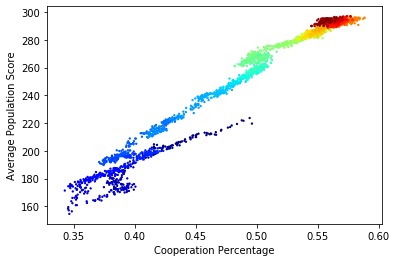

In [76]:
import matplotlib.cm as cm
cmap = cm.jet
c = np.linspace(0, 100, len(c_percent))

marker_size = 5000/len(scores)
plt.scatter(c_percent, scores, c=c, cmap=cmap,s=marker_size)
plt.xlabel('Cooperation Percentage')
plt.ylabel('Average Population Score')
plt.show()

0.02 of the original bots remain
278806


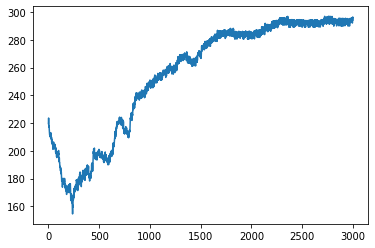

In [75]:
c_percent, scores = repeated_tournament(no_rounds=3000,fraction_discarded=50)
plt.plot(scores)
plt.show()

In [ ]:
# test_graph = gen_random_network(3)
# view_graph(test_graph)

In [ ]:
# x

In [199]:
import networkx as nx
G = nx.DiGraph()
G.add_edges_from([(1, 2), (1, 3)])
G.add_edges_from([(2, 1), (3, 4)])
G.edges()

OutEdgeView([(1, 2), (1, 3), (2, 1), (3, 4)])

In [29]:
z = gen_random_network()
view_nodes(z)

Node 0 strat is C, co-op is 1, defect is 1
Node 1 strat is C, co-op is 1, defect is 1


In [ ]:
# """
# This looks at how a population of automata and their strategies change over time, by having a
# tournament each generation within them, discarding the lowest peforming 
# automata, and replacing the gaps with randomly sampled automata


# """
# def repeated_tournament(no_rounds=30, pop_size=50, percentage_kept=0.9):
    
#     # Generates the initial population
#     graphs = [gen_random_network() for i in range(pop_size)]
#     pop = [Automaton(graphs[i]) for i in range(pop_size)]
    
#     # How much of the population should be kept
#     kept = int(pop_size*percentage_kept)
    
#     # Stores average scores
#     avg_scores = []
#     # Stores the percentage of cooperative states at each generation
#     c_percent = []
    
#     # Saving the scores of automata that play against each other
#     # So it doesn't need to recomputed for future generations
#     saved = {}
    
#     # Saves the original population to see how much is left by the end
#     original_pop = {hash(ind) for ind in pop}
    
#     for i in range(no_rounds):
#         # Gets co-operation percentage
#         c_percent.append(cooperate_percent(pop))
        
#         # Runs a tournament
#         res = tournament(pop_size, pop, saved)
#         scores = [x[0] for x in res]
#         bots = [x[1] for x in res]
        
#         # Gets the average scores
#         avg_scores.append(sum(scores)/len(scores))
        
#         # Keeps the top performing half
#         kept_bots = bots[:kept]
        
#         # Generates new bots
#         no_newbots = pop_size - kept
#         graphs = [gen_random_network() for i in range(no_newbots)]
#         new_bots = [Automaton(graphs[i]) for i in range(no_newbots)]
        
# #         print(len(kept_bots), len(new_bots))
#         pop = kept_bots + new_bots
    
#     # Determines what proportion of the orignal bots remain
#     seen = 0
#     for x in pop:
#         if hash(x) in original_pop:
#             seen += 1
    
#     print(f'{seen/pop_size} of the original bots remain')
    
#     # How many hashed scores are there
#     print(len(saved))
#     # Returns co-operation percentages and average scores of the generations
#     return c_percent, avg_scores
    